# Inverse distance weighting interpolation

Goal: Extract the weights and apply the IDW method excatly like the Python package, [pyinterp](https://pangeo-pyinterp.readthedocs.io)

In [1]:
import xarray as xr
import numpy as np
import xmitgcm
import sandbox as sb

import matplotlib.pyplot as plt
%matplotlib inline

Given NESBA track ranges

In [2]:
tm4 = [-sb.degMinSec2decimal(70,54.0876), #lon
       sb.degMinSec2decimal(39,50.8542)]  #lat
at  = [-sb.degMinSec2decimal(70,53.1670), 
       sb.degMinSec2decimal(39,57.1500)]
line= sb.gcspace(tm4, at, npts=5)

# Aste R1 Grid

Using and unstructured llc grid since NESBA4320 uses the same type of grid

In [3]:
from xmitgcm import llcreader
#import ecco_v4_py as ecco

In [4]:
aste = llcreader.SverdrupASTE270Model()
ds = aste.get_dataset(k_chunksize=90)

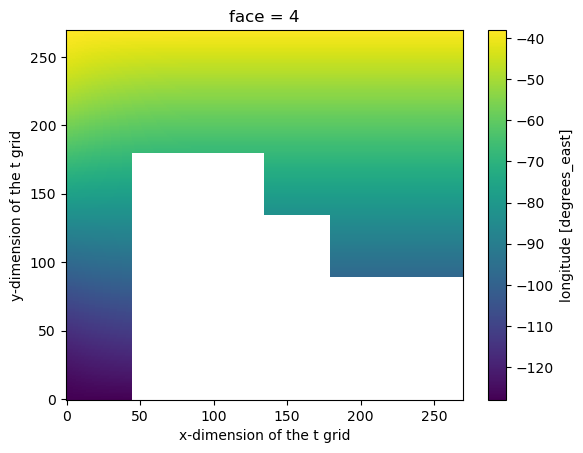

In [5]:
plt.figure()
ds.XC.isel(face=4).plot()

### subset data.

Would have preferred to do something with `where`

    dsNESBA = ds.where((ds.YC>=37) &  (ds.YC<=42) & (ds.XC>=-76) & (ds.XC<=-69), np.nan)
    
but this doesn't reduce the data size, it just replaces values to `np.nan`

In [6]:
ds = ds.isel(face=4, k=0).THETA.mean('time')

# PyInterp

Adapted from *IDW-weights_TUTORIAL.ipynb*

In [7]:
import pyinterp

**NOTE:** XC and YC data contained NaN's. I worked around this error by setting Nans to an unrealistic -400 degrees. This will only break the IDW interpolation if the points I interpolate to are near the NaN values XC/YC points. This probably won't ever happen since those point are deep inland. 

In [8]:
xc = ds.XC.fillna(-400)
yc = ds.YC.fillna(-400)

### Fill NanNs doesn't work with unstructured grids 🙄

Skip and avoid interpolation near land

In [9]:
mesh = pyinterp.RTree()

In [12]:
mesh.packing(np.vstack( (xc.values.ravel(),
                        yc.values.ravel()) ).T, 
             ds.values.ravel())

## Distances between 2D ihop range points to model grid

for points of **line**

In [13]:
def nearestIndicesLLC(ds, mesh, k=4):
    # for all points
    idList = []
    TOL = 1e-1
    lonN = xc.values
    latN = yc.values

    for lon, lat in zip(line[0], line[1]):
        lon = sb.lon180to360(lon)

        lons = xr.ones_like(ds.XC).values * lon
        lats = xr.ones_like(ds.YC).values * lat

        distquery = mesh.query(np.array([[lon,lat]]), k=k)
        distquery = distquery[0][0]

        distances = pyinterp.geodetic.coordinate_distances( 
                        lons.ravel(), lats.ravel(), 
                        lonN.ravel(), latN.ravel(),
                        strategy='vincenty')
        
        idLat = []; idLon = []
        for dist in distquery:
            for d in range(len(distances)):
                if abs(dist - distances[d]) < TOL:
                    (i,j) = np.unravel_index(d, lonN.shape)
                    idLat.append(i)
                    idLon.append(j)
                    
        idList.append([idLon, idLat, distquery])
    return idList

In [14]:
idList = nearestIndicesLLC(ds, mesh)

# Clone of IDW algo in RTree

the RTree is created from the BOOST Library (C++ code) so I'm unsure of the exact details of their implementation

    def calc_idw(dist, values):
    ww = sum(1/dist**2)
    u = 0
    for ii in range(len(dist)):
        u = u + values[ii]/dist[ii]**2/ww
    return u

### idList

Output is \[lon index\], \[lat index\], array\[idw weights\]

For llc rotated tile is \[i index\], \[j index\], array\[idw weights\]

In [15]:
idList[2]

[[173, 172, 173, 172],
 [171, 171, 170, 170],
 array([ 9232.95556338, 19333.24392393, 24567.85525021, 29838.28337408])]

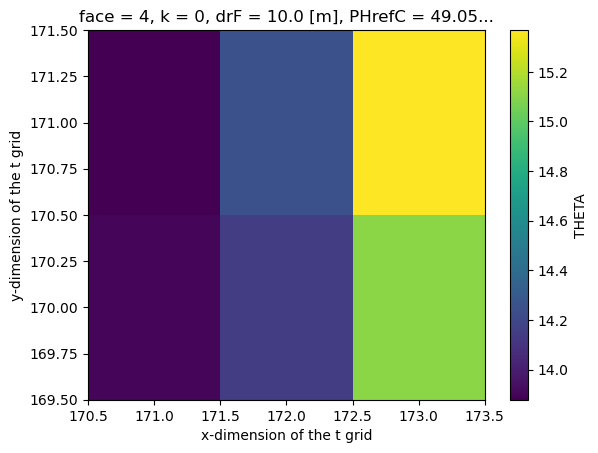

In [17]:
ds.isel(i=slice(171,174), j=slice(170,172)).plot()

## Compare to PyInterp IDW

Now, that I have the indices and weights, I should be able to reproduce IDW algo output

*Check* if distances are saem:

In [18]:
for ii in range(len(line[0])):
    for i,j,dists in zip(idList[ii][0],idList[ii][1], idList[ii][2]):
        lonA = np.array([line[0][ii]])
        latA = np.array([line[1][ii]])

        lonB = ds.XC.isel(j=j, i=i).values.item(); 
        lonB = np.array([lonB])
        latB = ds.YC.isel(j=j, i=i).values.item(); 
        latB = np.array([latB])

        qq = pyinterp.geodetic.coordinate_distances( 
                lonA, latA, 
                lonB, latB,
                strategy='vincenty')
        
        if (qq-dists) >= 0.035:
            print(qq-dists)

Find IDW algo interpolation result:

Use 3rd point in line

In [19]:
idw_theta, idw_neighbors = mesh.inverse_distance_weighting(
    np.vstack((line[0],line[1])).T, 
    within = True,
    #radius = 100000, #100 km radius
    k=4
)
idw_theta

array([15.36527412, 15.20183446, 15.08931859, 14.93190543, 14.75047233])

Calc my own IDW manually:

Overwriting the distances, since I don't need those written to file

In [20]:
for i in range(len(idList)):
    dist = idList[i][2]
    idList[i][2] = 1/dist**2

Calc in a function:

In [21]:
def calc_idw_w_weights(ds, idList):
    idLon = idList[0]
    idLat = idList[1]
    weights = idList[2]
    
    u = 0
    for ii in range(len(idLon)):
        u = u + ds.isel(i=idLon[ii],j=idLat[ii])*weights[ii]
    return u / sum(weights)

In [22]:
for i in range(len(idw_theta)):
    print(calc_idw_w_weights(ds, idList[i]).values - idw_theta[i])

-6.46533289128115e-07
-7.376795263525082e-07
6.364046196694062e-07
-6.356064758961111e-07
-2.6285539256321044e-07


<sub> Written by Escobar, I. on October 2022 </sub>